In [1]:
path = "C:/Users/Chigozie/Documents/data science/analyticsvidya_data/bigMartSales"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random

In [4]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import catboost as cat
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression

In [5]:
#FOR PREPRODUCIBILITY
seed= 2020
np.random.seed(seed)

In [6]:
%matplotlib inline
pd.set_option('display.max_columns', 50)
plt.style.use('bmh')

In [7]:
def randomColors(seed=42):
    """
    Random color generator
    :Returns Hex colors
    """
    np.random.RandomState(seed)
    colors = [i for i in range(0,10)]+['A', 'B', 'C', 'D', 'E']
    color= np.random.choice(colors, 6, replace=False)
    return '#'+''.join(color)

In [8]:
train = pd.read_csv(path+'/Train_cleaned.csv')
test = pd.read_csv(path+'/Test_cleaned.csv')
subfile = pd.read_table(path+'/SampleSubmission.txt', sep=',')

In [9]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Store_Unique_Items,Store_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,3,Tier 1,Supermarket Type1,3735.1380,9,21
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,3,Tier 3,Supermarket Type2,443.4228,9,11
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,3,Tier 1,Supermarket Type1,2097.2700,10,21
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,1,Tier 3,Grocery Store,732.3800,9,22
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,4,Tier 3,Supermarket Type1,994.7052,9,33


In [10]:
test.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Store_Unique_Items,Store_Age
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,3,Tier 1,Supermarket Type1,9,21
1,FDW14,8.30,Regular,0.038428,Dairy,87.3198,OUT017,2007,1,Tier 2,Supermarket Type1,9,13
2,NCN55,14.60,Low Fat,0.099575,Others,241.7538,OUT010,1998,1,Tier 3,Grocery Store,9,22


In [11]:
test_ids = test[['Item_Identifier', 'Outlet_Identifier']]

In [12]:
cat_cols = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 
            'Outlet_Identifier','Outlet_Location_Type','Outlet_Type']

**Label Encoding**

In [13]:
for col in cat_cols:
    lb_enc = LabelEncoder()
    train[col] = lb_enc.fit_transform(train[col])
    test[col] = lb_enc.transform(test[col])

In [14]:
features = train.columns.drop(['Item_Outlet_Sales'])

In [41]:
def model_train(model, df, test_df, n_folds=5):
    """
    Function for Training Model
    :params model: Instantiated model
    :params df: Train data
    :params test_df: Test_data
    :returns test_predictions
    """
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    for f, (tr_idx, val_idx) in enumerate(kfold.split(
        df.drop('Item_Outlet_Sales', axis=1), df.Item_Outlet_Sales)):
        
        df.loc[val_idx, 'kfold'] = f
    
    #shuffling data
    df = df.sample(frac=1, random_state=seed)#seed for reproducibility
    
    features =  [col for col in df.columns if col not in ['Item_Outlet_Sales', 'kfold']]
    
    tr_avg, val_avg = 0, 0
    test_preds= []
    train_preds = np.zeros(len(df))
    xtest = test_df #test set
    
    for fold_ in range(n_folds):
        
        train_df = df[df.kfold != fold_]
        val_df = df[df.kfold == fold_]
        
        xtrain, ytrain = train_df[features], np.log(train_df.Item_Outlet_Sales)
        xval, yval = val_df[features], np.log(val_df.Item_Outlet_Sales)
        
        #fitting
        if model.__class__.__name__ in ['XGBRegressor', 'CatBoostRegressor', 'LGBMRegressor']:
            model.fit(xtrain, ytrain, eval_set=[(xval, yval)], early_stopping_rounds=250, verbose=False)
        else:       
            model.fit(xtrain, ytrain)
        
        preds = model.predict(xval)
        val_rmse = mean_squared_error(np.exp(yval), np.exp(preds), squared=False) #Squaring both actual and predictions
        tr_rmse = mean_squared_error(np.exp(ytrain), np.exp(model.predict(xtrain)), squared=False)
        
        tr_avg += tr_rmse
        val_avg += val_rmse
        
        train_pred = np.exp(model.predict(xval))
        train_preds[val_df.index] = train_pred
        #predicting Test set
        test_pred = np.exp(model.predict(xtest))
        test_preds.append(test_pred)
        
        print(f'Fold {fold_+1}\tTrain RMSE: {tr_rmse.round(4)}, Val RMSE: {val_rmse.round(4)}')
    print()
    print(f'AVG Train RMSE: {(tr_avg/(n_folds)).round(4)}, AVG Val RMSE: {(val_avg/n_folds).round(4)}')
    return np.mean(test_preds, 0).astype('float32'), train_preds.astype('float32')

In [42]:
def StackModels(meta_estimator, train_stack, test_stack, target):
    preds = meta_estimator.fit(train_stack, target).predict(test_stack)
    return preds

In [43]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_leaf=10, 
                           min_samples_split=5, random_state=seed, max_features=0.5)

gbm = GradientBoostingRegressor(n_estimators=700, max_depth=3, max_features=0.5, validation_fraction=0.1, 
                                learning_rate=0.07, min_samples_leaf=3, random_state=seed, min_samples_split=2, 
                                n_iter_no_change=100)

lgbm = lgb.LGBMRegressor(n_estimators=900, learning_rate=0.009, min_child_samples=10, min_child_weight=3,
                         metrics='rmse', max_depth=3, num_leaves=16, colsample_bytree=0.7, 
                         subsample_freq=2, random_state=seed, reg_lambda=3)

catm  = cat.CatBoostRegressor(random_seed=seed, learning_rate=0.02, n_estimators=700, silent=True, rsm=0.7, 
                              bootstrap_type='Bernoulli', max_depth=4)

xgbm = xgb.XGBRegressor(random_state=seed, colsample_bytree=0.7, n_estimators=900, learning_rate=0.009, 
                        min_child_weight=1, reg_lambda=2, n_jobs=-1, max_depth=3, eval_metric='rmse')

In [44]:
lgbm = lgb.LGBMRegressor(n_estimators=900, learning_rate=0.009, min_child_samples=10, min_child_weight=3,
                         metrics='rmse', max_depth=3, num_leaves=16, colsample_bytree=0.7, 
                         subsample_freq=2, random_state=seed, reg_lambda=3)

**Training and Predictions**

In [45]:
rf_pred, rf_tr = model_train(rf, train, test, n_folds=7)

Fold 1	Train RMSE: 966.4859, Val RMSE: 1106.5043
Fold 2	Train RMSE: 963.1378, Val RMSE: 1121.9002
Fold 3	Train RMSE: 957.5551, Val RMSE: 1159.5445
Fold 4	Train RMSE: 955.875, Val RMSE: 1161.4951
Fold 5	Train RMSE: 963.2329, Val RMSE: 1104.9288
Fold 6	Train RMSE: 967.5189, Val RMSE: 1096.1094
Fold 7	Train RMSE: 966.1673, Val RMSE: 1107.4563

AVG Train RMSE: 962.8532, AVG Val RMSE: 1122.5627


In [46]:
gbm_pred, gbm_tr = model_train(gbm, train, test, n_folds=7)

Fold 1	Train RMSE: 1087.588, Val RMSE: 1098.4536
Fold 2	Train RMSE: 1081.3134, Val RMSE: 1122.1559
Fold 3	Train RMSE: 1072.2294, Val RMSE: 1150.1298
Fold 4	Train RMSE: 1068.6707, Val RMSE: 1146.7769
Fold 5	Train RMSE: 1081.0968, Val RMSE: 1098.668
Fold 6	Train RMSE: 1079.0054, Val RMSE: 1090.0597
Fold 7	Train RMSE: 1076.7809, Val RMSE: 1107.6849

AVG Train RMSE: 1078.0978, AVG Val RMSE: 1116.2756


In [47]:
xgb_pred, xgb_tr = model_train(xgbm, train, test, n_folds=7)

Fold 1	Train RMSE: 1094.6329, Val RMSE: 1096.795
Fold 2	Train RMSE: 1089.4379, Val RMSE: 1120.7572
Fold 3	Train RMSE: 1096.8876, Val RMSE: 1152.5913
Fold 4	Train RMSE: 1083.9398, Val RMSE: 1147.2796
Fold 5	Train RMSE: 1099.8902, Val RMSE: 1097.7099
Fold 6	Train RMSE: 1117.2671, Val RMSE: 1109.1496
Fold 7	Train RMSE: 1104.0854, Val RMSE: 1114.037

AVG Train RMSE: 1098.0201, AVG Val RMSE: 1119.76


In [48]:
lgb_pred, lgb_tr = model_train(lgbm, train, test, n_folds=7)

Fold 1	Train RMSE: 1094.3818, Val RMSE: 1094.1656
Fold 2	Train RMSE: 1090.3889, Val RMSE: 1117.2838
Fold 3	Train RMSE: 1094.4087, Val RMSE: 1141.8692
Fold 4	Train RMSE: 1092.2825, Val RMSE: 1147.0222
Fold 5	Train RMSE: 1106.638, Val RMSE: 1099.6896
Fold 6	Train RMSE: 1101.1401, Val RMSE: 1094.1155
Fold 7	Train RMSE: 1096.7084, Val RMSE: 1105.1621

AVG Train RMSE: 1096.5641, AVG Val RMSE: 1114.1869


In [49]:
cat_pred, cat_tr = model_train(catm, train, test, n_folds=7)

Fold 1	Train RMSE: 1092.3251, Val RMSE: 1090.7969
Fold 2	Train RMSE: 1092.9951, Val RMSE: 1113.9127
Fold 3	Train RMSE: 1092.393, Val RMSE: 1133.4503
Fold 4	Train RMSE: 1099.418, Val RMSE: 1143.7278
Fold 5	Train RMSE: 1112.1339, Val RMSE: 1098.3171
Fold 6	Train RMSE: 1097.6575, Val RMSE: 1090.2206
Fold 7	Train RMSE: 1094.114, Val RMSE: 1103.989

AVG Train RMSE: 1097.2909, AVG Val RMSE: 1110.6306


In [50]:
def featureImportance(model,ax=None):
    return pd.Series(model.feature_importances_, index=features).sort_values().plot.barh(
        ax=ax, title=model.__class__.__name__)

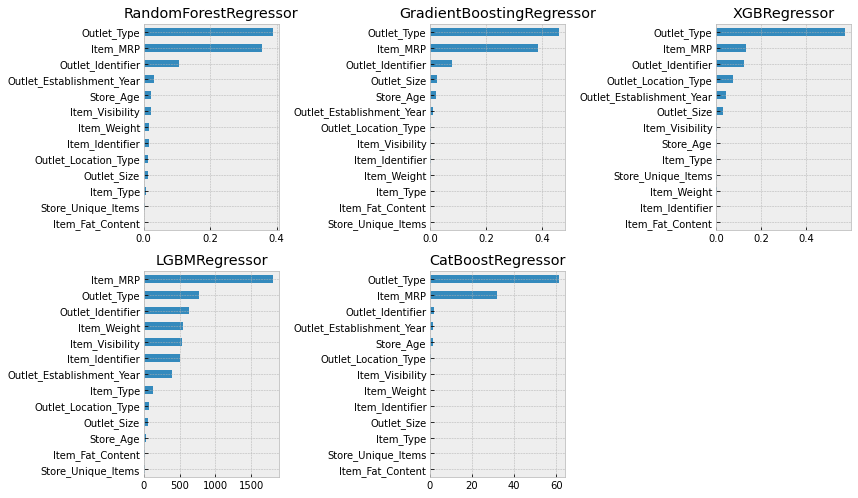

In [66]:
plt.figure(figsize=(12,7))
for i, model in enumerate([rf, gbm, xgbm, lgbm, catm], start=1):
    plt.subplot(2,3,i)
    featureImportance(model)
plt.tight_layout(pad=1.);

**Stacking**

In [67]:
linreg = LinearRegression()

In [68]:
test_stack = np.c_[rf_pred, gbm_pred, xgb_pred, lgb_pred, cat_pred]
train_stack = np.c_[rf_tr, gbm_tr, xgb_tr, lgb_tr, cat_tr]
target= train.Item_Outlet_Sales.values

In [69]:
stack_pred = StackModels(linreg, train_stack, test_stack, target)

In [70]:
stack_pred

array([1702.749  , 1401.388  ,  556.56506, ..., 1926.8154 , 3557.2056 ,
       1268.4092 ], dtype=float32)

In [74]:
rf_pred.max(), gbm_pred.max(), xgb_pred.max(), lgb_pred.max(), cat_pred.max(), stack_pred.max()

(6027.3574, 6220.096, 5779.5444, 5856.4556, 5887.446, 6926.3916)

**Submissions**

In [56]:
rf_df = subfile.copy()
rf_df['Item_Outlet_Sales'] = rf_pred

In [57]:
gbm_df = subfile.copy()
gbm_df['Item_Outlet_Sales'] = gbm_pred

In [58]:
lgb_df = subfile.copy()
lgb_df['Item_Outlet_Sales'] = lgb_pred

In [59]:
xgb_df = subfile.copy()
xgb_df['Item_Outlet_Sales'] = xgb_pred

In [60]:
cat_df = subfile.copy()
cat_df['Item_Outlet_Sales'] = cat_pred

In [61]:
stack_df = subfile.copy()
stack_df['Item_Outlet_Sales'] = stack_pred

In [62]:
preds = pd.DataFrame(np.c_[rf_pred, gbm_pred, xgb_pred, lgb_pred, cat_pred, stack_pred], 
                     columns=['rf', 'gbm', 'xgb', 'lgb', 'cat', 'stack'])

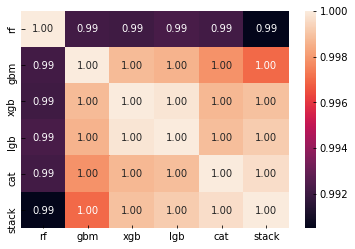

In [63]:
sns.heatmap(preds.corr(), annot=True, fmt='.2f');

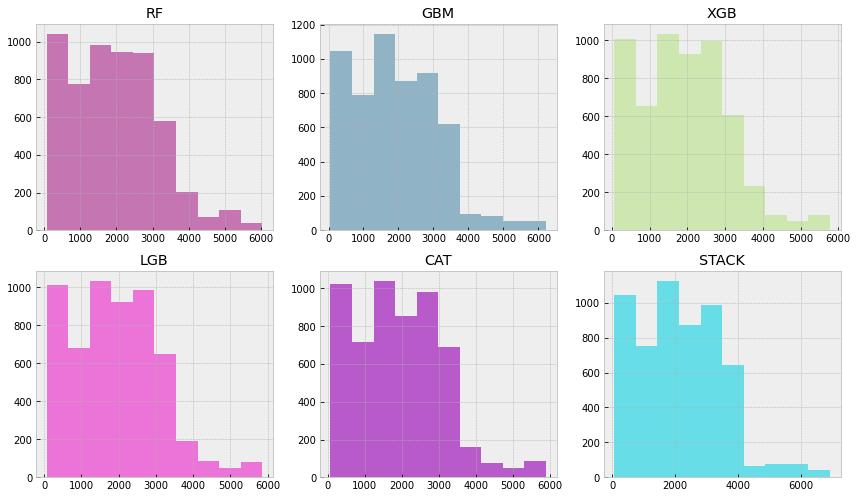

In [64]:
plt.figure(figsize=(12,7))
for i, (model_pred, model_title) in enumerate(zip([rf_pred, gbm_pred, xgb_pred, lgb_pred, cat_pred, stack_pred], 
                                                ['RF', 'GBM', 'XGB', 'LGB', 'CAT', 'STACK']), start=1):
    plt.subplot(2,3,i)
    plt.hist(model_pred, color=randomColors(), alpha=0.75)
    plt.title(model_title)
plt.tight_layout(pad=1.);

**Saving Submissions**

In [65]:
rf_df.to_csv(path+'/predictions/rf.csv', index=False)
gbm_df.to_csv(path+'/predictions/gbm.csv', index=False)
xgb_df.to_csv(path+'/predictions/xgb.csv', index=False)
lgb_df.to_csv(path+'/predictions/lgb.csv', index=False)
cat_df.to_csv(path+'/predictions/cat.csv', index=False)
stack_df.to_csv(path+'/predictions/stack.csv', index=False)

In [40]:
gc.collect()

19921